In [1]:
# 구글 코랩에서 데이터셋 다운로드 및 준비
from google.colab import files
files.upload()  # 'kaggle.json' 파일 업로드

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d misrakahmed/vegetable-image-dataset

# 압축 해제
!unzip vegetable-image-dataset.zip -d vegetable-image-dataset

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0001.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0002.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0003.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0004.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0005.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0006.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0007.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0008.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0009.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0010.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0011.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0012.jpg  
  inflating: vegetable-image

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_path = "./vegetable-image-dataset/Vegetable Images/"
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# 학습 데이터 로드
train_generator = train_datagen.flow_from_directory(
    directory=f"{data_path}/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",  # One-hot encoding
    shuffle=True
)

# 검증 데이터 로드
val_generator = val_test_datagen.flow_from_directory(
    directory=f"{data_path}/validation",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False  # 순서 유지
)

# 테스트 데이터 로드
test_generator = val_test_datagen.flow_from_directory(
    directory=f"{data_path}/test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# ResNet18 불러오기 (사전 훈련된 가중치 사용)
model = models.resnet18(pretrained=True)

# 마지막 FC 레이어 변경 (15개 클래스 기준)
num_classes = 15  # 분류할 클래스 개수
model.fc = nn.Linear(model.fc.in_features, num_classes)

# GPU 사용 가능하면 GPU로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("ResNet18 모델 준비 완료!")
print(model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]


ResNet18 모델 준비 완료!
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Re

In [4]:
# 손실 함수 (Categorical CrossEntropy Loss)
criterion = nn.CrossEntropyLoss()

# 옵티마이저 (Adam 사용)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 학습률 감소 (ReduceLROnPlateau) 적용
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3)


In [15]:
import sqlite3
from datetime import datetime

# 1. DB 연결 및 테이블 생성
conn = sqlite3.connect("training_logs.db")
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE IF NOT EXISTS training_logs (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    epoch INTEGER,
    start_time TEXT,
    end_time TEXT,
    train_loss REAL,
    val_loss REAL,
    train_acc REAL,
    val_acc REAL
)
""")
conn.commit()

# 2. 로그 저장 함수 정의
def save_log_to_sqlite(epoch, start_time, end_time, train_loss, val_loss, train_acc, val_acc):
    cursor.execute("""
        INSERT INTO training_logs (
            epoch, start_time, end_time,
            train_loss, val_loss,
            train_acc, val_acc
        )
        VALUES (?, ?, ?, ?, ?, ?, ?)
    """, (
        epoch,
        start_time.isoformat(),
        end_time.isoformat(),
        train_loss,
        val_loss,
        train_acc,
        val_acc
    ))
    conn.commit()

In [21]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        start_time = datetime.now()
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        # 학습 (Training)
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        train_acc = 100 * train_correct / train_total
        history["train_loss"].append(train_loss / len(train_loader))
        history["train_acc"].append(train_acc)

        # 검증 (Validation)
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = 100 * val_correct / val_total

        history["val_loss"].append(val_loss / len(val_loader))
        history["val_acc"].append(val_acc)

        end_time = datetime.now()

        save_log_to_sqlite(
            epoch=epoch + 1,
            start_time=start_time,
            end_time=end_time,
            train_loss=history["train_loss"][-1],
            val_loss=history["val_loss"][-1],
            train_acc=history["train_acc"][-1],
            val_acc=history["val_acc"][-1]
        )

        if epoch == 0 or val_acc > best_val_acc:
          best_val_acc = val_acc
          torch.save(model.state_dict(), "best_resnet18.pth")
          print(f"모델 저장됨 (epoch {epoch+1}, val_acc: {val_acc:.2f}%)")

          # 스케줄러 업데이트 (학습률 감소)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

    return history  # 학습 기록 반환


In [22]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# transform 정의 (ResNet18에 맞는 형식으로 변환)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 크기 조정
    transforms.ToTensor(),  # (H, W, C) → (C, H, W) 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

# ImageFolder를 사용하여 데이터셋 로드 (train_generator 대체)
train_dataset = datasets.ImageFolder(root="/content/vegetable-image-dataset/Vegetable Images/train", transform=transform)
val_dataset = datasets.ImageFolder(root="/content/vegetable-image-dataset/Vegetable Images/validation", transform=transform)
test_dataset = datasets.ImageFolder(root="/content/vegetable-image-dataset/Vegetable Images/test", transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("transform이 적용된 DataLoader 생성 완료!")


transform이 적용된 DataLoader 생성 완료!


In [23]:
num_epochs = 10  # 학습 횟수 설정

# 학습 실행
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)


모델 저장됨 (epoch 1, val_acc: 99.93%)
Epoch 1/10 - Train Loss: 0.1970 - Train Acc: 100.00% - Val Loss: 0.1753 - Val Acc: 99.93%
Epoch 2/10 - Train Loss: 0.1606 - Train Acc: 100.00% - Val Loss: 0.1553 - Val Acc: 99.93%
모델 저장됨 (epoch 3, val_acc: 99.97%)
Epoch 3/10 - Train Loss: 0.1355 - Train Acc: 100.00% - Val Loss: 0.1215 - Val Acc: 99.97%
Epoch 4/10 - Train Loss: 0.1253 - Train Acc: 100.00% - Val Loss: 0.1413 - Val Acc: 99.93%
Epoch 5/10 - Train Loss: 0.0923 - Train Acc: 100.00% - Val Loss: 0.0727 - Val Acc: 99.97%
Epoch 6/10 - Train Loss: 0.0885 - Train Acc: 100.00% - Val Loss: 0.1184 - Val Acc: 99.93%
Epoch 7/10 - Train Loss: 0.1285 - Train Acc: 99.99% - Val Loss: 0.0810 - Val Acc: 99.97%
Epoch 8/10 - Train Loss: 0.0599 - Train Acc: 100.00% - Val Loss: 0.0759 - Val Acc: 99.97%
Epoch 9/10 - Train Loss: 0.0598 - Train Acc: 100.00% - Val Loss: 0.0914 - Val Acc: 99.93%
Epoch 10/10 - Train Loss: 0.0951 - Train Acc: 99.99% - Val Loss: 0.0863 - Val Acc: 99.97%


In [24]:
import torch
import torch.nn.functional as F

# 저장된 모델 로드
model.load_state_dict(torch.load("best_resnet18.pth"))
model.to(device)
model.eval()

# 테스트 평가
test_loss, test_correct, test_total = 0.0, 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)  # 테스트 손실 계산
        test_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

# 평균 Test Loss & Accuracy 계산
test_loss /= len(test_loader)
test_acc = 100 * test_correct / test_total

print(f"최종 테스트 손실: {test_loss:.4f}")
print(f"최종 테스트 정확도: {test_acc:.2f}%")


최종 테스트 손실: 0.0016
최종 테스트 정확도: 99.97%


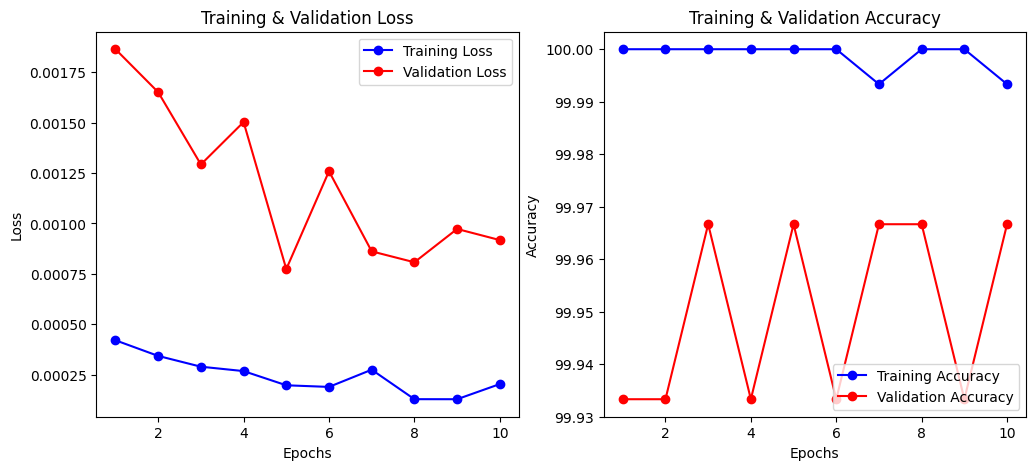

In [25]:
# 학습 기록을 활용한 그래프 그리기
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"]) + 1)

# Loss 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], 'bo-', label="Training Loss")
plt.plot(epochs, history["val_loss"], 'ro-', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], 'bo-', label="Training Accuracy")
plt.plot(epochs, history["val_acc"], 'ro-', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()
